## 第5章: 係り受け解析
日本語Wikipediaの「人工知能」に関する記事からテキスト部分を抜き出したファイルがai.ja.zipに収録されている．

この文章をCaboChaやKNP等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．

このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

In [10]:
# 行数の確認
!wc -l ./ai.ja.txt.parsed

   11744 ./ai.ja.txt.parsed


In [11]:
# 先頭15行の確認
!head -15 ./ai.ja.txt.parsed

* 0 -1D 1/1 0.000000
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
EOS
EOS
* 0 17D 1/1 0.388993
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
* 1 17D 2/3 0.613549
（	記号,括弧開,*,*,*,*,（,（,（
じん	名詞,一般,*,*,*,*,じん,ジン,ジン
こうち	名詞,一般,*,*,*,*,こうち,コウチ,コーチ
のう	助詞,終助詞,*,*,*,*,のう,ノウ,ノー
、	記号,読点,*,*,*,*,、,、,、
、	記号,読点,*,*,*,*,、,、,、


### 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．

このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．

さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

※ メンバ変数とは、「通常 self.variable_name の形式で記述される」変数のこと

In [14]:
parse_file = 'ai.ja.txt.parsed'

class Morph:
  def __init__(self, morph):
    # 入力部分をタブで分割し、それぞれを格納
    surface, attr = morph.split('\t')
    attr = attr.split(',')
    self.surface = surface
    self.base = attr[6]
    self.pos = attr[0]
    self.pos1 = attr[1]

sentences = []
morphs = []
# ファイルを開く
with open(parse_file, mode='r') as f:
  # １行ずつ取り出して操作
  for line in f:
    # 取り込んだ最初が「*」なら飛ばす
    if line[0] == '*':
      continue
    # 取り込んだ要素が「EOS」以外ならリストに追加する
    elif line != 'EOS\n':
      morphs.append(Morph(line))
    # 取り込んだ要素が「EOS」なら、文章の終わりなので、溜まったmorphリストをsentencesリストに追加する
    else:
      sentences.append(morphs)
      morphs = []

# 確認
for m in sentences[2]:
  print(vars(m))


{'surface': '人工', 'base': '人工', 'pos': '名詞', 'pos1': '一般'}
{'surface': '知能', 'base': '知能', 'pos': '名詞', 'pos1': '一般'}
{'surface': '（', 'base': '（', 'pos': '記号', 'pos1': '括弧開'}
{'surface': 'じん', 'base': 'じん', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'こうち', 'base': 'こうち', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'のう', 'base': 'のう', 'pos': '助詞', 'pos1': '終助詞'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': 'AI', 'base': '*\n', 'pos': '名詞', 'pos1': '一般'}
{'surface': '〈', 'base': '〈', 'pos': '記号', 'pos1': '括弧開'}
{'surface': 'エーアイ', 'base': '*\n', 'pos': '名詞', 'pos1': '固有名詞'}
{'surface': '〉', 'base': '〉', 'pos': '記号', 'pos1': '括弧閉'}
{'surface': '）', 'base': '）', 'pos': '記号', 'pos1': '括弧閉'}
{'surface': 'と', 'base': 'と', 'pos': '助詞', 'pos1': '格助詞'}
{'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': '「', 'base': '「', 'pos': '記号', 'pos1': '括弧開'}
{

### 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．

このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．

さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [31]:
class Chunk():
  def __init__(self, morphs, dst):
    self.morphs = morphs
    self.dst = dst
    self.srcs = []

class Sentence():
  def __init__(self, chunks):
    self.chunks = chunks

    # chunksを１行ずつ取り出す
    for i, chunk in enumerate(self.chunks):
      # chunksが持っているdst属性を参照する
      if not chunk.dst != -1:
        self.chunks[chunk.dst].srcs.append(i)


In [33]:
parse_file = 'ai.ja.txt.parsed'

sentences = [] # 各文章を加えていく
chunks = []    # 各文節を加えていく
morphs = []    # 各形態素を加えていく
with open(parse_file, mode='r') as f:a
  dst = -1
  for line in f:
    if line[0] == '*':
      # morphsに形態素が入っている（つまり、前の文節が終了した）ことを確認
      if len(morphs) > 0:
        chunks.append(Chunk(morphs, dst))
        morphs = []
      dst = int(line.split(' ')[2].rstrip('D'))
    elif line != 'EOS\n':
      morphs.append(Morph(line))
    else:
      chunks.append(Chunk(morphs, dst))
      sentences.append(Sentence(chunks))
      morphs = []
      chunks = []
      dst = None

# 確認
for chunk in sentences[2].chunks:
  print([morph.surface for morph in chunk.morphs], chunk.dst, chunk.srcs)

['人工', '知能'] 17 []
['（', 'じん', 'こうち', 'のう', '、', '、'] 17 []
['AI'] 3 []
['〈', 'エーアイ', '〉', '）', 'と', 'は', '、'] 17 []
['「', '『', '計算'] 5 []
['（', '）', '』', 'という'] 9 []
['概念', 'と'] 9 []
['『', 'コンピュータ'] 8 []
['（', '）', '』', 'という'] 9 []
['道具', 'を'] 10 []
['用い', 'て'] 12 []
['『', '知能', '』', 'を'] 12 []
['研究', 'する'] 13 []
['計算', '機', '科学'] 14 []
['（', '）', 'の'] 15 []
['一', '分野', '」', 'を'] 16 []
['指す'] 17 []
['語', '。'] 34 []
['「', '言語', 'の'] 20 []
['理解', 'や'] 20 []
['推論', '、'] 21 []
['問題', '解決', 'など', 'の'] 22 []
['知的', '行動', 'を'] 24 []
['人間', 'に'] 24 []
['代わっ', 'て'] 26 []
['コンピューター', 'に'] 26 []
['行わ', 'せる'] 27 []
['技術', '」', '、', 'または', '、'] 34 []
['「', '計算', '機'] 29 []
['（', 'コンピュータ', '）', 'による'] 31 []
['知的', 'な'] 31 []
['情報処理', 'システム', 'の'] 33 []
['設計', 'や'] 33 []
['実現', 'に関する'] 34 []
['研究', '分野', '」', 'と', 'も'] 35 []
['さ', 'れる', '。'] -1 [35]


### 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [37]:
sentence = sentences[2]
for chunk in sentence.chunks:
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
    print(modifier, modifiee, sep='\t')

人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [38]:
sentence = sentences[2]
for chunk in sentence.chunks:
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
    # 係る方の品詞を登録
    modifier_pos = [morph.pos for morph in chunk.morphs]
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
    # 係られる方の品詞を登録
    modifiee_pos = [morph.pos for morph in sentence.chunks[int(chunk.dst)].morphs]

    if '名詞' in modifier_pos and '動詞' in modifiee_pos:
      print(modifier, modifiee, sep='\t')

道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される


### 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい．

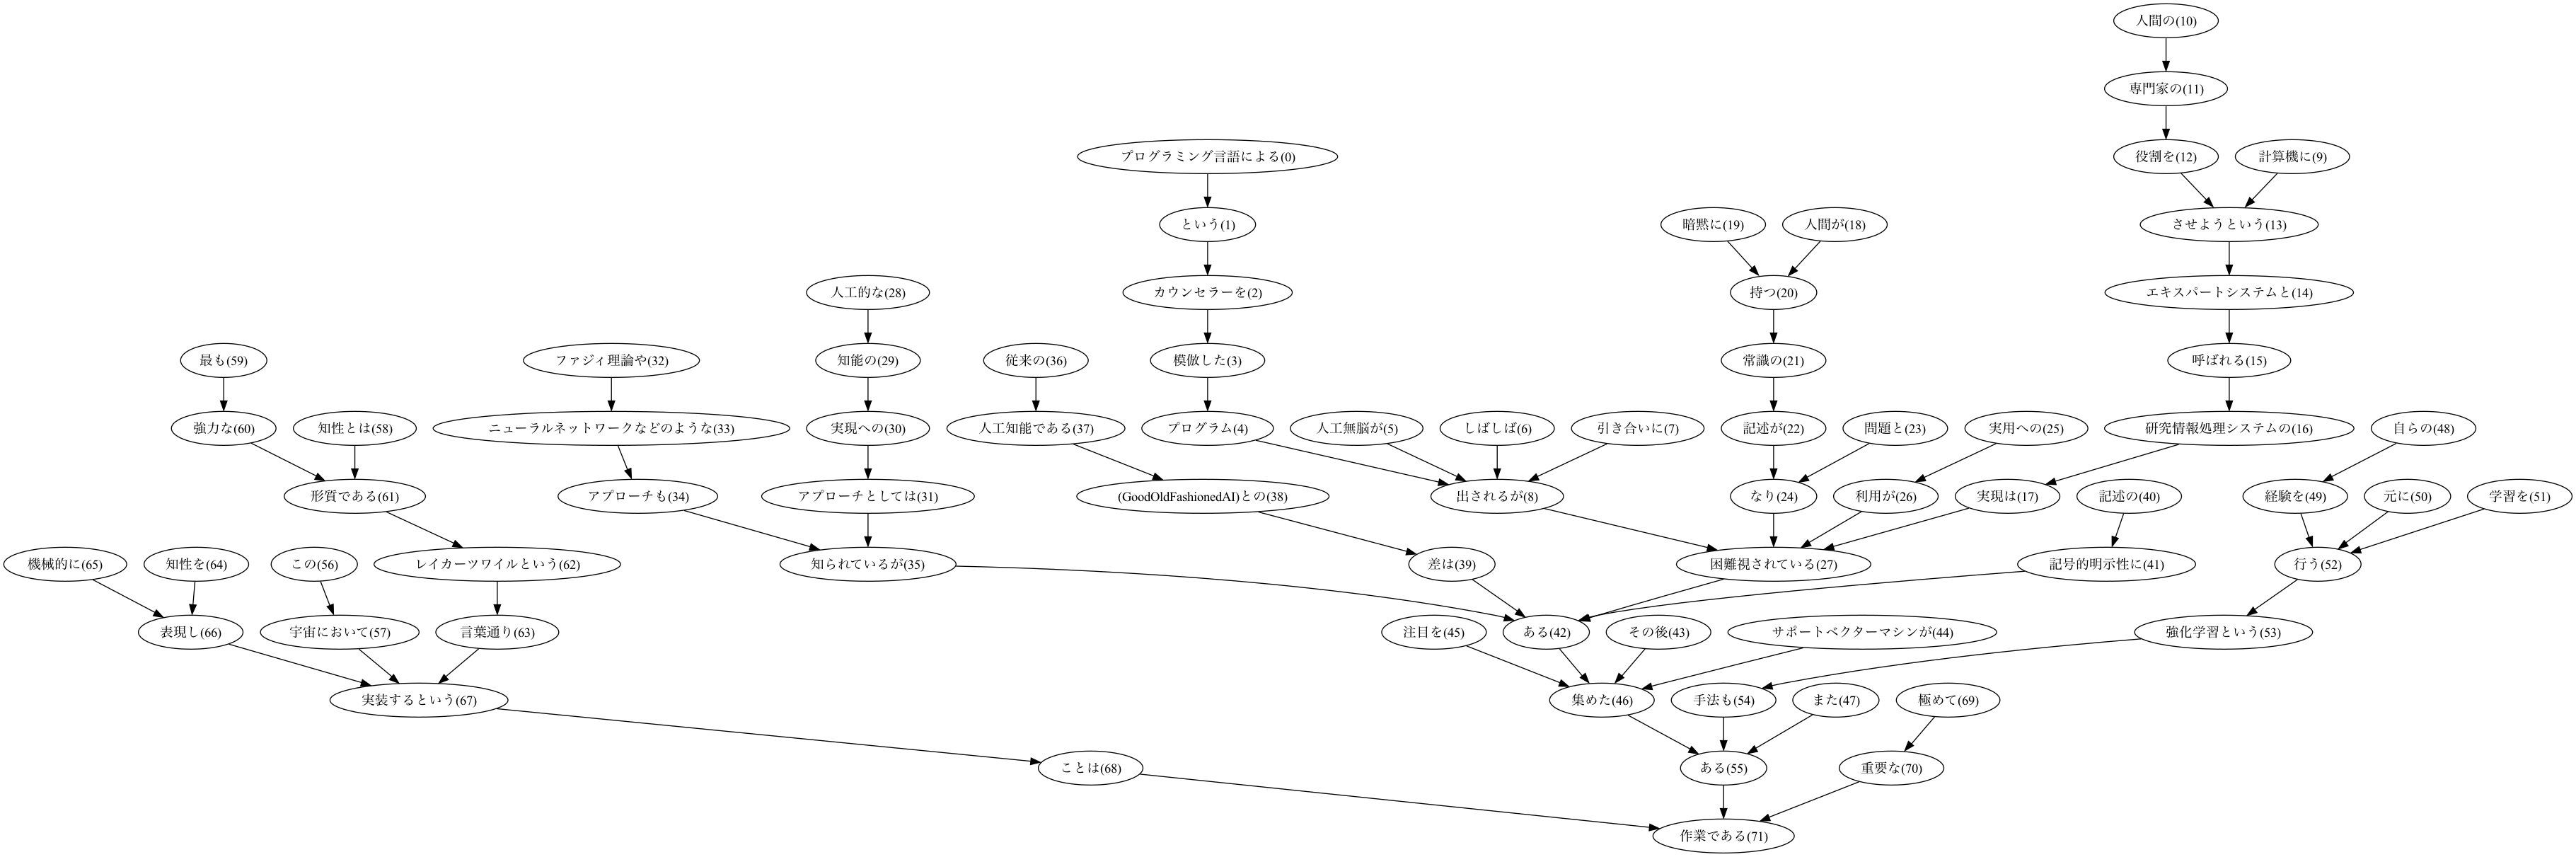

In [48]:
import pydot
from IPython.display import Image,display_png
from graphviz import Digraph

sentence = sentences[7]
edges = []
for id, chunk in enumerate(sentence.chunks):
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs] + ['(' + str(id) + ')'])
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs] + ['(' + str(chunk.dst) + ')'])
    edges.append([modifier, modifiee])
n = pydot.Node('node')
n.fontname = 'IPAGothic'
g = pydot.graph_from_edges(edges, directed=True)
g.add_node(n)
g.write_png('./ans44.png')
display_png(Image('./ans44.png'))

### 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ．

ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [50]:
with open('./ans45.txt', 'w') as f:
  for sentence in sentences:
    for chunk in sentence.chunks:
      for morph in chunk.morphs:
        # chunkの左から順番に動詞を探す
        if morph.pos == '動詞':
          cases = []
          for src in chunk.srcs:
            # 見つけた動詞の係り元chunkから助詞を探す
            cases = cases + [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
          if len(cases) > 0: # casesの長さは助詞の長さ、0より大きいということは助詞があるということ
            cases = sorted(list(set(cases)))
            line = '{}\t{}'.format(morph.base, ' '.join(cases))
            print(line, file=f)
          break

In [51]:
# 確認
!cat ./ans45.txt | sort | uniq -c | sort -nr | head -n 10

  12 する	て
   2 述べる	て
   1 進める	て
   1 通じる	て
   1 考える	て
   1 答える	て
   1 目立つ	に
   1 挙げる	て
   1 行う	て
   1 示す	て
